In [35]:
import numpy as np
import pandas as pd
import catboost as cat
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x) 
pd.options.display.max_rows = 200

In [36]:
train_df = pd.read_csv('./join_train_raw.csv')
test_df = pd.read_csv('./join_test_raw.csv')
train_df.head()

,poi_id,request_id,pos,time,action,uuid,request_cate_id,request_time,latitude_req,longitude_req,...,age,job,cate_level1,cate_level2,cate_level3,area_id,avg_price,poi_star,longitude_poi,latitude_poi
0,1702902487627383470,4311086084099128885,13,2019-05-02,0,9639065597435420672.00000,1.00000,16:20:24,29.17869,105.75189,...,nan,1.00000,226,201,2036,15743,66.00000,43.00000,105.71669,29.16793
1,14800569415264211896,4749834003306548820,1,2019-05-02,0,1328961192981608192.00000,1.00000,19:19:03,38.00386,105.46219,...,nan,3.00000,226,201,244,31806,49.00000,37.00000,105.44020,38.06025
2,6279863632342018475,13389247690348720622,83,2019-05-02,0,10690361122658435072.00000,1.00000,17:39:57,22.04956,112.60320,...,20.00000,3.00000,226,249,12,6941,49.00000,48.00000,112.56872,22.08056
3,11127900293242244072,3988416664035581676,43,2019-05-02,0,3636211028573041664.00000,1.00000,22:31:17,30.22583,120.40876,...,18.00000,2.00000,226,308,321,35343,100.00000,39.00000,119.34878,29.81518
4,15471065569104080361,17230175878920950111,13,2019-05-02,0,4344247626277908992.00000,1.00000,18:30:24,43.41147,86.72988,...,31.00000,1.00000,226,235,235,34029,107.00000,50.00000,86.77066,43.40464


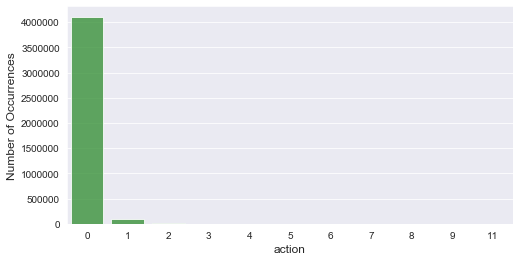

In [37]:
cnt_srs = train_df['action'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('action', fontsize=12)
plt.show()



In [38]:
train_df['action'].ix[train_df['action']>1]=1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [39]:
train_df[train_df['action']>1]

,poi_id,request_id,pos,time,action,uuid,request_cate_id,request_time,latitude_req,longitude_req,...,age,job,cate_level1,cate_level2,cate_level3,area_id,avg_price,poi_star,longitude_poi,latitude_poi


In [40]:
#fillna of the missing lon&lat
# 用poi的做填充
train_df['latitude_req'].fillna(train_df['latitude_poi'],inplace=True)
train_df['longitude_req'].fillna(train_df['longitude_poi'],inplace=True)

test_df['latitude_req'].fillna(test_df['latitude_poi'],inplace=True)
test_df['longitude_req'].fillna(test_df['longitude_poi'],inplace=True)

In [41]:
def geodistance(lat_req, lng_req, lat_poi, lng_poi):
    dlon = lng_req - lng_poi
    dlat = lat_req - lat_poi
    a = np.sin(dlat / 2) ** 2 + np.cos(lat_req) * np.cos(lat_poi) * np.sin(dlon / 2) ** 2
    distance = 2 * np.arcsin(np.sqrt(a)) * 6371 * 1000 # 地球平均半径，6371km
    distance = round(distance / 1000, 3)
    return distance
p = math.pi
train_df['distance'] = geodistance(train_df['latitude_req']/180*p, train_df['longitude_req']/180*p, train_df['latitude_poi']/180*p, train_df['longitude_poi']/180*p)
test_df['distance'] = geodistance(test_df['latitude_req']/180*p, test_df['longitude_req']/180*p, test_df['latitude_poi']/180*p, test_df['longitude_poi']/180*p)

In [42]:
train_df.head()

,poi_id,request_id,pos,time,action,uuid,request_cate_id,request_time,latitude_req,longitude_req,...,job,cate_level1,cate_level2,cate_level3,area_id,avg_price,poi_star,longitude_poi,latitude_poi,distance
0,1702902487627383470,4311086084099128885,13,2019-05-02,0,9639065597435420672.00000,1.00000,16:20:24,29.17869,105.75189,...,1.00000,226,201,2036,15743,66.00000,43.00000,105.71669,29.16793,3.62100
1,14800569415264211896,4749834003306548820,1,2019-05-02,0,1328961192981608192.00000,1.00000,19:19:03,38.00386,105.46219,...,3.00000,226,201,244,31806,49.00000,37.00000,105.44020,38.06025,6.56000
2,6279863632342018475,13389247690348720622,83,2019-05-02,0,10690361122658435072.00000,1.00000,17:39:57,22.04956,112.60320,...,3.00000,226,249,12,6941,49.00000,48.00000,112.56872,22.08056,4.95100
3,11127900293242244072,3988416664035581676,43,2019-05-02,0,3636211028573041664.00000,1.00000,22:31:17,30.22583,120.40876,...,2.00000,226,308,321,35343,100.00000,39.00000,119.34878,29.81518,111.80200
4,15471065569104080361,17230175878920950111,13,2019-05-02,0,4344247626277908992.00000,1.00000,18:30:24,43.41147,86.72988,...,1.00000,226,235,235,34029,107.00000,50.00000,86.77066,43.40464,3.38000


In [43]:
## Peak
#req_time in train_data
train_df["request_time"] = pd.to_datetime(train_df["request_time"])
train_df["request_time"] = train_df["request_time"].dt.hour
test_df["request_time"] = pd.to_datetime(test_df["request_time"])
test_df["request_time"] = test_df["request_time"].dt.hour

train_df['peak'] = train_df['request_time']
test_df['peak']  = test_df['request_time']

In [44]:
def judgePeak(data):
    thre = 1
    #train_df['peak'].ix[(abs(train_df['peak']-12)>thre) and (abs(train_df['peak']-18)>thre)] = 0
    #train_df['peak'].ix[(abs(train_df['peak']-12)<=thre) or (abs(train_df['peak']-18)<=thre)] = 1
    data['peak'].ix[data['peak']==1] = 0
    data['peak'].ix[abs(data['peak']-12)<=thre] = 1
    data['peak'].ix[abs(data['peak']-18)<=thre] = 1
    data['peak'].ix[data['peak']!=1] = 0
judgePeak(train_df)
judgePeak(test_df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarn

In [45]:
cnt_peak = train_df['peak'].value_counts()
print(cnt_peak)
cnt_peak1 = test_df['peak'].value_counts()
print(cnt_peak1)

1    2387018
0    1819046
Name: peak, dtype: int64
1.00000    110973
0.00000     81027
Name: peak, dtype: int64


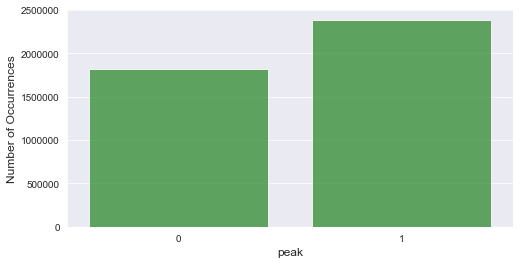

In [46]:
cnt_p=train_df['peak'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(cnt_p.index, cnt_p.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('peak', fontsize=12)
plt.show()

In [47]:
train_df.head()

,poi_id,request_id,pos,time,action,uuid,request_cate_id,request_time,latitude_req,longitude_req,...,cate_level1,cate_level2,cate_level3,area_id,avg_price,poi_star,longitude_poi,latitude_poi,distance,peak
0,1702902487627383470,4311086084099128885,13,2019-05-02,0,9639065597435420672.00000,1.00000,16,29.17869,105.75189,...,226,201,2036,15743,66.00000,43.00000,105.71669,29.16793,3.62100,0
1,14800569415264211896,4749834003306548820,1,2019-05-02,0,1328961192981608192.00000,1.00000,19,38.00386,105.46219,...,226,201,244,31806,49.00000,37.00000,105.44020,38.06025,6.56000,1
2,6279863632342018475,13389247690348720622,83,2019-05-02,0,10690361122658435072.00000,1.00000,17,22.04956,112.60320,...,226,249,12,6941,49.00000,48.00000,112.56872,22.08056,4.95100,1
3,11127900293242244072,3988416664035581676,43,2019-05-02,0,3636211028573041664.00000,1.00000,22,30.22583,120.40876,...,226,308,321,35343,100.00000,39.00000,119.34878,29.81518,111.80200,0
4,15471065569104080361,17230175878920950111,13,2019-05-02,0,4344247626277908992.00000,1.00000,18,43.41147,86.72988,...,226,235,235,34029,107.00000,50.00000,86.77066,43.40464,3.38000,1


In [48]:
test_df.head()

,ID,poi_id,request_id,time,uuid,request_cate_id,request_time,latitude_req,longitude_req,device_type,...,cate_level1,cate_level2,cate_level3,area_id,avg_price,poi_star,longitude_poi,latitude_poi,distance,peak
0,0,9112213143968062524,8673569280272624492,2019-05-24,16158156245467033600.00000,1.00000,11.00000,39.36692,118.68695,IPHONE,...,226,2164,2045,6572,65.00000,50.00000,118.68965,39.37796,1.25000,1.00000
1,1,53557027324898748,6863006006010879698,2019-05-24,16150361091820490752.00000,1.00000,19.00000,35.72888,112.30123,ANDROID,...,226,315,220,5,48.00000,50.00000,112.29320,35.74877,2.32700,1.00000
2,2,12902939766658959016,18376791302553851667,2019-05-24,8684960388314220544.00000,1.00000,10.00000,39.51715,115.60384,IPHONE,...,226,315,220,12952,191.00000,50.00000,115.60928,39.51530,0.51000,0.00000
3,3,2481639352755945782,15242768632323808713,2019-05-24,7071432869505742848.00000,1.00000,10.00000,22.77923,115.96795,ANDROID,...,226,319,2114,33982,111.00000,50.00000,115.93084,22.90505,14.49800,0.00000
4,4,4818803223655004342,15017009482150386668,2019-05-24,13920009043869528064.00000,1.00000,19.00000,22.76764,112.44958,IPHONE,...,226,249,12,20361,139.00000,50.00000,112.46442,22.78504,2.46200,1.00000


In [ ]:
train_df.to_csv('./train_data_1112.csv', index = False)

In [ ]:
test_df.to_csv('./test_data_1112.csv', index = False)

In [49]:
table_deal = pd.read_csv('./table_deal_detail.csv')
table_deal.head()

,poi_id,deal_id,price,discount_price
0,16299742064226140594,910890292437756613,106.00000,78.00000
1,16299742064226140594,3500359259416935814,255.00000,199.00000
2,16299742064226140594,5082200941301010306,84.00000,68.00000
3,16299742064226140594,2390209155982821145,84.00000,59.00000
4,9134060278671452229,8657241870770382155,30.00000,19.90000


In [58]:
table_deal['rate']=table_deal['discount_price']/table_deal['price']

In [59]:
table_deal.head()

,poi_id,deal_id,price,discount_price,rate
0,16299742064226140594,910890292437756613,106.00000,78.00000,0.73585
1,16299742064226140594,3500359259416935814,255.00000,199.00000,0.78039
2,16299742064226140594,5082200941301010306,84.00000,68.00000,0.80952
3,16299742064226140594,2390209155982821145,84.00000,59.00000,0.70238
4,9134060278671452229,8657241870770382155,30.00000,19.90000,0.66333


In [ ]:
#figure out the avg_discount_rate & discount number

In [72]:
poi_count = dict(table_deal['poi_id'].value_counts())
poi_rate  = {}
for poi in poi_count:
    tmp_df = table_deal[table_deal['poi_id']==poi]
    rate_sum = tmp_df['rate'].sum()
    poi_rate[poi] = rate_sum/poi_count[poi]

In [97]:
pd.DataFrame(list(poi_count_df.items()))
pd.DataFrame(list(poi_rate_df.items()))

poi_count_df = pd.DataFrame(list(poi_count.items()))
poi_rate_df  = pd.DataFrame(list(poi_rate.items()))

In [98]:
poi_count_df.columns = ['poi_id','poi_cnt_deal']
poi_rate_df.columns = ['poi_id','poi_avg_discount']

In [103]:
poi_count_df.head()

,poi_id,poi_cnt_deal
0,10787770906520280678,30
1,7730191978042495921,30
2,17644832638786097490,30
3,17741528728919149792,30
4,14539209999969858980,30


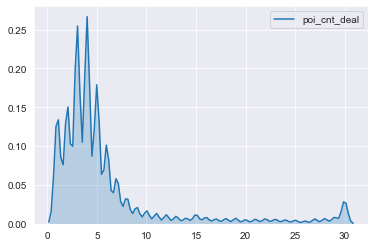

In [113]:
# Visualization
sns.kdeplot(poi_count_df['poi_cnt_deal'],shade=True)
plt.show()

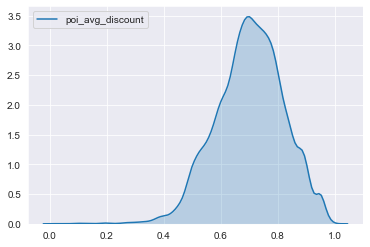

In [115]:
# Visualization
sns.kdeplot(poi_rate_df['poi_avg_discount'],shade=True)
plt.show()

In [101]:
train_df_merge1 = pd.merge(train_df,poi_count_df,how='left',on='poi_id')
train_df_merge2 = pd.merge(train_df_merge1,poi_rate_df,how='left',on='poi_id')

In [117]:
test_df_merge1 = pd.merge(test_df,poi_count_df,how='left',on='poi_id')
test_df_merge2 = pd.merge(test_df_merge1,poi_rate_df,how='left',on='poi_id')

In [119]:
test_df_merge2.head()

,ID,poi_id,request_id,time,uuid,request_cate_id,request_time,latitude_req,longitude_req,device_type,...,cate_level3,area_id,avg_price,poi_star,longitude_poi,latitude_poi,distance,peak,poi_cnt_deal,poi_avg_discount
0,0,9112213143968062524,8673569280272624492,2019-05-24,16158156245467033600.00000,1.00000,11.00000,39.36692,118.68695,IPHONE,...,2045,6572,65.00000,50.00000,118.68965,39.37796,1.25000,1.00000,3.00000,0.70101
1,1,53557027324898748,6863006006010879698,2019-05-24,16150361091820490752.00000,1.00000,19.00000,35.72888,112.30123,ANDROID,...,220,5,48.00000,50.00000,112.29320,35.74877,2.32700,1.00000,3.00000,0.76503
2,2,12902939766658959016,18376791302553851667,2019-05-24,8684960388314220544.00000,1.00000,10.00000,39.51715,115.60384,IPHONE,...,220,12952,191.00000,50.00000,115.60928,39.51530,0.51000,0.00000,nan,nan
3,3,2481639352755945782,15242768632323808713,2019-05-24,7071432869505742848.00000,1.00000,10.00000,22.77923,115.96795,ANDROID,...,2114,33982,111.00000,50.00000,115.93084,22.90505,14.49800,0.00000,4.00000,0.82216
4,4,4818803223655004342,15017009482150386668,2019-05-24,13920009043869528064.00000,1.00000,19.00000,22.76764,112.44958,IPHONE,...,12,20361,139.00000,50.00000,112.46442,22.78504,2.46200,1.00000,30.00000,0.64736


In [120]:
train_df_merge2.to_csv('./train_data_1112.csv', index = False)
test_df_merge2.to_csv('./test_data_1112.csv', index = False)

In [107]:
train_df_merge2.head()

,poi_id,request_id,pos,time,action,uuid,request_cate_id,request_time,latitude_req,longitude_req,...,cate_level3,area_id,avg_price,poi_star,longitude_poi,latitude_poi,distance,peak,poi_cnt_deal,poi_avg_discount
0,1702902487627383470,4311086084099128885,13,2019-05-02,0,9639065597435420672.00000,1.00000,16,29.17869,105.75189,...,2036,15743,66.00000,43.00000,105.71669,29.16793,3.62100,0,5.00000,0.73786
1,14800569415264211896,4749834003306548820,1,2019-05-02,0,1328961192981608192.00000,1.00000,19,38.00386,105.46219,...,244,31806,49.00000,37.00000,105.44020,38.06025,6.56000,1,4.00000,0.79159
2,6279863632342018475,13389247690348720622,83,2019-05-02,0,10690361122658435072.00000,1.00000,17,22.04956,112.60320,...,12,6941,49.00000,48.00000,112.56872,22.08056,4.95100,1,7.00000,0.73344
3,11127900293242244072,3988416664035581676,43,2019-05-02,0,3636211028573041664.00000,1.00000,22,30.22583,120.40876,...,321,35343,100.00000,39.00000,119.34878,29.81518,111.80200,0,3.00000,0.57121
4,15471065569104080361,17230175878920950111,13,2019-05-02,0,4344247626277908992.00000,1.00000,18,43.41147,86.72988,...,235,34029,107.00000,50.00000,86.77066,43.40464,3.38000,1,7.00000,0.53511


In [ ]:
train_df.to_csv('./train_data_1112.csv', index = False)

In [50]:
df = pd.DataFrame({"name":["apple", "pear", "pig", "dog", "cat"], "number_1":[1,np.nan,3,np.nan,5], "number_2":[np.nan, 2,3,4,5]})
print(len(df))

5


In [51]:
print(df)

    name  number_1  number_2
0  apple   1.00000       nan
1   pear       nan   2.00000
2    pig   3.00000   3.00000
3    dog       nan   4.00000
4    cat   5.00000   5.00000


In [54]:
df['number_1'].sum()

9.0